In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import agent
from gridworld_with_door import MazeEnvironment
from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
from mile1.rnn_agent import RNNAgent as RNNAgent
from state_update.bootstrap_agent import RNNAgent as BootAgent
from IPython.display import HTML, Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# enable if ffmpeg codec is installed 
# plt.rcParams['animation.ffmpeg_path'] = '/anaconda3/envs/pytorch/bin/ffmpeg'

In [3]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

### Long dependency

In [4]:
#### Limitation RNN GRU

### Buffer Training

In [5]:
### state dist investigation

### Helpers

In [6]:
def run_episode(env, agent, state_visits=None, keep_history=False):
    is_terminal = False
    sum_of_rewards = 0
    step_count = 0
    
    obs = env.env_start(keep_history=keep_history)
    action = agent.agent_start(obs)
    
    if state_visits is not None:
        state_visits[obs[0]] += 1

    while not is_terminal:
        reward, obs, is_terminal = env.env_step(action)
        print(agent.steps,end='\r')
        sum_of_rewards -= 1
        step_count += 1
        state = obs
        if step_count == 500:
            agent.agent_end(reward, state, append_buffer=False)
            break
        elif is_terminal:
            agent.agent_end(reward, state, append_buffer=True)
        else:
            action = agent.agent_step(reward, state)

        if state_visits is not None:
            state_visits[state[0]] += 1
    
    if keep_history:
        history = env.history
        env.env_cleanup()
        return sum_of_rewards, history
    else:
        return sum_of_rewards

In [7]:
def animate(history, name='history.gif'):
    frames = len(history)
    print(f"Rendering {frames} frames...")
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)

    def render_frame(i):
        grid = history[i]
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
    anim = animation.FuncAnimation(fig, render_frame, frames=frames, interval=100);
    plt.close(anim._fig)
    # Option a) if ffmpeg codec is installed, display animation with ffmpeg
    # display(HTML(anim.to_html5_video()))
    # Option b) save as gif and display
    anim.save(name, dpi=80, writer=animation.PillowWriter(fps=20));
    with open(name,'rb') as file:
        display(Image(file.read()))

### Experiment Setup

In [8]:
def reload(obj):
   import inspect
   import imp
   cur_mod = inspect.getmodule(obj)
   imp.reload(cur_mod)
   mod_name = cur_mod.__name__
   obj_name = obj.__name__
   #from mod_name import obj_name as obj
   return getattr(__import__(mod_name, fromlist=[obj_name]), obj_name)

In [48]:
RNNAgent = reload(RNNAgent)
BootAgent = reload(BootAgent)

agents = {
#     "RNN": RNNAgent,
    "Boot": BootAgent,
}

In [42]:
def to_list(tups):
    return [list(x) for x in tups]

In [43]:
def get_env_info(n):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-1,m-1]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [44]:
def get_env_info_for_room(n,a=1):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-a,m-a]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [45]:
envs = {
    'Grid-World': MazeEnvironment,
}
agent_infos = {
    "NN": {"step_size": 3e-3},
    "RNN": {"step_size": 1e-3},
    "GRU": {"step_size": 3e-4},
#     "FPP": {"step_size": 3e-4, "beta":1.5},
    "FPP": {'discount': 0.9, 'beta': 0.5, 'step_size': 0.001},
    "UORO": {"step_size": 3e-4},
    "Boot":  {'beta': 0.5, 'step_size': 0.001},
}

env_infos = {
#     "simp": {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 0], 
#         "end_state": [6, 6],
#     }, 
#     'obs': {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 0], 
#         "end_state": [6, 6],
#         "obstacles": [[3, 3], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#     },
    'DoorWorldHallway': {
        "maze_dim": [1, 7], 
        "start_state": [0, 2], 
        "end_state": [0, 0],
        "obstacles":[[0,1]],
        "doors": {tuple([0,6]):[[0,1]]},
    },
    'DoorWorldWide1': {
        "maze_dim": [7, 7], 
        "start_state": [0, 6], 
        "end_state": [6, 6],
        "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
        "doors": {tuple([2,2]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
    },
    'DoorWorldWide2': {
        "maze_dim": [7, 7], 
        "start_state": [0, 6], 
        "end_state": [6, 6],
        "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
        "doors": {tuple([1,1]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
    },
    'DoorWorldWide3': {
        "maze_dim": [7, 7], 
        "start_state": [0, 6], 
        "end_state": [6, 6],
        "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
        "doors": {tuple([0,0]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
    },
#     'DoorWorldWide3.5': {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 6], 
#         "end_state": [6, 6],
#         "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#         "doors": {tuple([6,0]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
#     },
#     'DoorWorldWide4': {
#         "maze_dim": [11, 11], 
#         "start_state": [0, 10], 
#         "end_state": [10, 10],
#         "obstacles": to_list([*zip([5]*6,range(5,11)), *zip(range(6,11), [5]*5)]),
#         "doors": {tuple([4,4]):to_list([*zip([5]*6,range(6,11))])},
#     },
#     'DoorWorldWide5': get_env_info(13),
#     'DoorWorldWide6': get_env_info(15),
#     'DoorWorldWide7': get_env_info_for_room(13,2),
#     'DoorWorldWide8': get_env_info_for_room(13,4),
#     'DoorWorldWide9': get_env_info_for_room(15,2),
#     'DoorWorldWide10': get_env_info_for_room(15,3),
#     'DoorWorldWide11': get_env_info_for_room(15,4),

}

### Train

In [46]:
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_history = {}

In [32]:
# all_reward_sums['NN'] = []
# all_reward_sums_sarsa_tile_4 = all_reward_sums['Sarsa']
# all_reward_sums['Sarsa'] = []

In [49]:
num_runs = 1
num_episodes = 500
Environment = envs['Grid-World']

mb = master_bar(env_infos.items())

for env_name, env_info in mb:
    if env_name not in all_reward_sums:
        all_reward_sums[env_name] = {}
        all_state_visits[env_name] = {}
        print(env_name)
    for algorithm in progress_bar(list(agents.keys()), parent=mb):
        all_reward_sums[env_name][algorithm] = []
        all_state_visits[env_name][algorithm] = []
        for run in tqdm(range(num_runs)):
            agent = agents[algorithm]()
            env = Environment()
            env.env_init(env_info)
#             print(env_info)
            agent_info = {"num_actions": 4, "num_states": env.cols * env.rows, "epsilon": .1, "step_size": 0.5, "discount": .9} 
            agent_info["seed"] = run
            agent_info.update(agent_infos[algorithm])
            np.random.seed(run)
            agent.agent_init(agent_info)

            reward_sums = []
            state_visits = np.zeros(env.cols * env.rows)
            epsilon = 1
            for episode in range(num_episodes):
    #             if episode < 50:
    #                 agent.epsilon = 1 
    #             else:
    #                 agent.epsilon = .1 
                print(f"episode {episode}",end='\r')
                agent.epsilon = epsilon
                if episode < num_episodes - 10:
                    sum_of_rewards = run_episode(env, agent) 
                else: 
                    # Runs an episode while keeping track of visited states and history
                    sum_of_rewards, history = run_episode(env, agent, state_visits, keep_history=True)
                    all_history.setdefault(env_name, {}).setdefault(algorithm, []).append(history)
                epsilon *= 0.99
                reward_sums.append(sum_of_rewards)

            all_reward_sums[env_name].setdefault(algorithm, []).append(reward_sums)
            all_state_visits[env_name].setdefault(algorithm, []).append(state_visits)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:48<00:00, 108.45s/it]

DoorWorldWide1


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:47<00:00, 107.54s/it]

DoorWorldWide2


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [04:10<00:00, 250.33s/it]

DoorWorldWide3


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [15:55<00:00, 955.59s/it]

In [ ]:
agent.rnn.actions

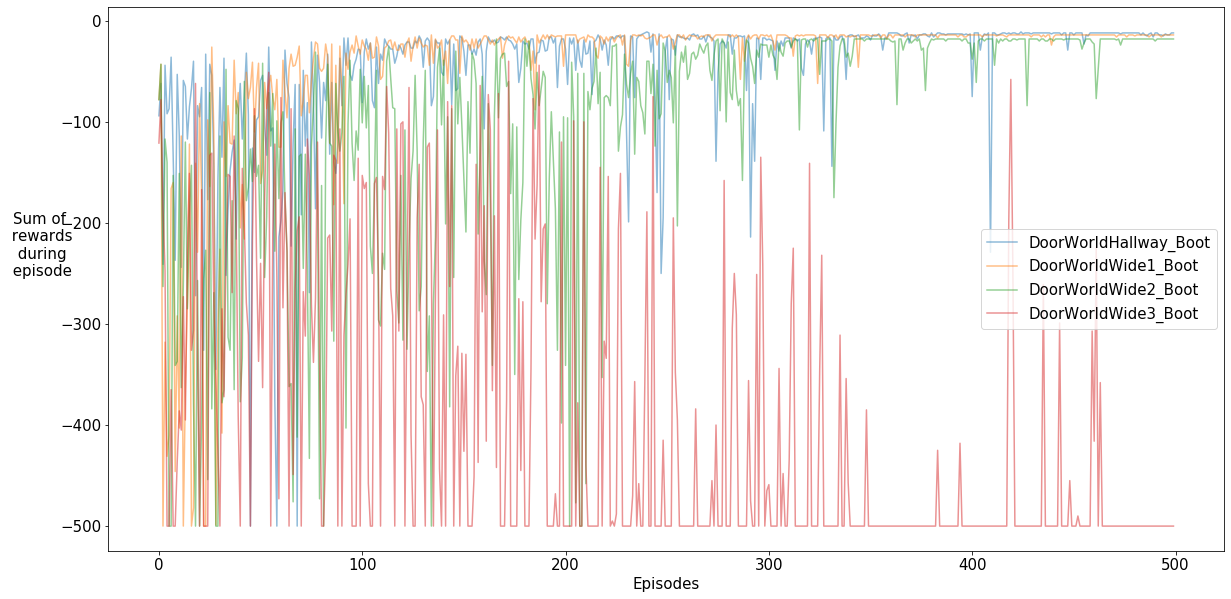

In [50]:
tmp={}
tmp1={'DoorWorldWide10':'DoorWorldWide13X13D2','DoorWorldWide11':'DoorWorldWide13X13D4'}
plt.figure(figsize=(20,10))
for env in env_infos:
    for i, algorithm in enumerate(list(agents.keys())):
        if algorithm not in all_reward_sums[env]:
            continue
        algorithm_means = np.mean(all_reward_sums[env][algorithm], axis=0)
        algorithm_stds = np.std(all_reward_sums[env][algorithm], axis=0)
        plt.plot(algorithm_means, label=tmp1.get(env,env)+'_'+tmp.get(algorithm, algorithm),
                 alpha=0.5)
        plt.fill_between(range(num_episodes), algorithm_means + algorithm_stds/np.sqrt(num_runs), algorithm_means - algorithm_stds/np.sqrt(num_runs), alpha=0.2)
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=20)
plt.xlabel("Episodes")
# plt.ylim(-100,10)
# plt.plot([0,500],[-24,-24])

plt.legend()
plt.show()


In [67]:
len(all_reward_sums[env]['FPP'])

2

In [51]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldHallway Boot -44.766
DoorWorldWide1 Boot -42.728
DoorWorldWide2 Boot -99.402
DoorWorldWide3 Boot -400.896


In [40]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldHallway RNN -41.678
DoorWorldHallway Boot -51.92
DoorWorldWide1 RNN -36.446
DoorWorldWide1 Boot -42.35
DoorWorldWide2 RNN -63.614
DoorWorldWide2 Boot -71.186
DoorWorldWide3 RNN -409.532
DoorWorldWide3 Boot -393.362


In [307]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldWide3 NN -367.3005
DoorWorldWide3 RNN -359.1444
DoorWorldWide3 GRU -115.0744
DoorWorldWide3 FPP -318.34866666666665
DoorWorldWide3 UORO -222.342


In [284]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldWide3 NN -346.442
DoorWorldWide3 RNN -158.992
DoorWorldWide3 GRU -245.722
DoorWorldWide3 FPP -136.99
DoorWorldWide3 UORO -222.342


In [145]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,300:]),)

DoorWorldWide10 GRU -50.105
DoorWorldWide10 GRU_Trace -52.623333333333335
DoorWorldWide11 GRU -858.3966666666666
DoorWorldWide11 GRU_Trace -154.625


In [132]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldWide1 NN -410.331
DoorWorldWide1 RNN -471.735
DoorWorldWide1 GRU -109.797
DoorWorldWide2 NN -301.685
DoorWorldWide2 RNN -73.734
DoorWorldWide2 GRU -53.833
DoorWorldWide3 NN -31.132
DoorWorldWide3 RNN -40.411
DoorWorldWide3 GRU -35.956


Rendering 19 frames...


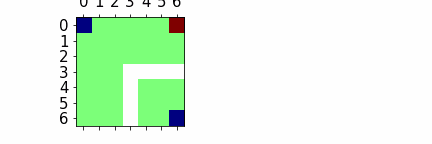

In [289]:
animate(all_history['DoorWorldWide3']['FPP'][-1][-100:])

Rendering 100 frames...


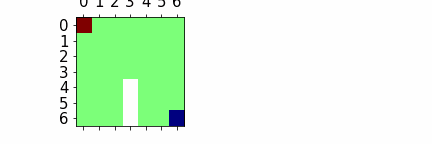

In [121]:
animate(all_history['DoorWorldWide3']['RNN'][-1][-100:])

Rendering 100 frames...


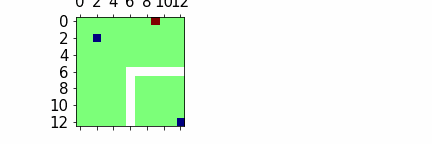

In [120]:
animate(all_history['DoorWorldWide8']['GRU'][-1][-100:])

Rendering 100 frames...


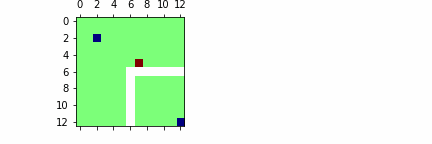

In [152]:
animate(all_history['DoorWorldWide11']['GRU_Trace'][-1][-100:])

Rendering 86 frames...


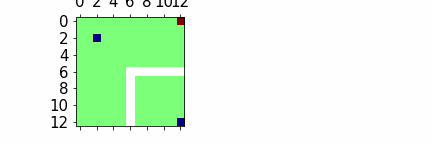

In [111]:
animate(all_history[env]['GRU'][-1][-100:])

Rendering 100 frames...


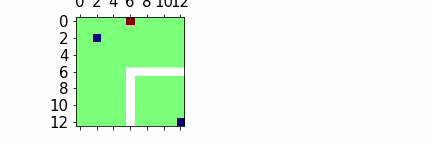

In [112]:
animate(all_history[env]['GRU_Trace'][-1][-100:])

Rendering 31 frames...


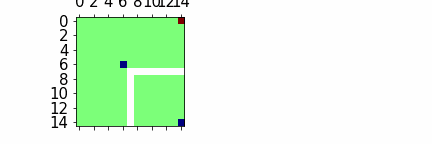

In [102]:
animate(all_history['DoorWorldWide6']['GRU'][-1][-100:])

Rendering 15 frames...


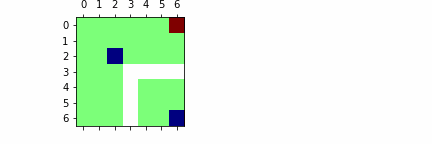

In [137]:
animate(all_history[env]['GRU'][-1][-100:])

Rendering 19 frames...


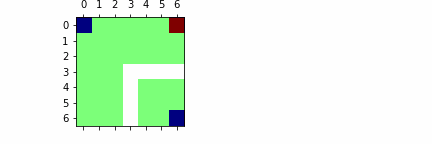

In [138]:
animate(all_history['GRU'][0][-100:])

Rendering 17 frames...


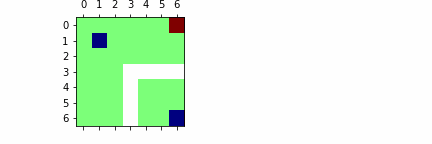

In [142]:
animate(all_history['GRU'][25][-100:])

In [143]:
exp1_reward_sums = all_reward_sums 
exp1_state_visits = all_state_visits

Rendering 100 frames...


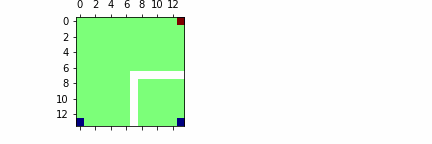

In [166]:
animate(temp[0]['NN'][0][-100:])

In [163]:
temp = list(all_history.values())

In [164]:
temp[0]['NN']

dict_keys(['NN'])

### Test

In [130]:
env = Environment()
env.env_init(env_info)
env.env_start()

(12, False)

In [124]:
import torch

In [125]:
def mask_grid(grid, blocks, mask_value=-100):
   for i in range(grid.shape[0]):
       for j in range(grid.shape[1]):
           if [i,j] in blocks:
               grid[i,j] = mask_value
   grid = np.ma.masked_where(grid == mask_value, grid)
   return grid

In [126]:
hidden = agent.rnn.initHidden()

In [131]:
agent.get_state_feature(env.get_state_features([0,6]))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [132]:
def get_action_values_matrix(state):
    state = agent.get_state_feature(env.get_state_features(state))
    with torch.no_grad():
        current_q, _ = agent.rnn(state, hidden)
    current_q.squeeze_()
    temp = np.zeros((3,3))
    temp[0,1] = current_q[0]
    temp[1,2] = current_q[1]
    temp[2,1] = current_q[2]
    temp[1,0] = current_q[3]
#     temp[1,1] = current_q[4]
    return temp



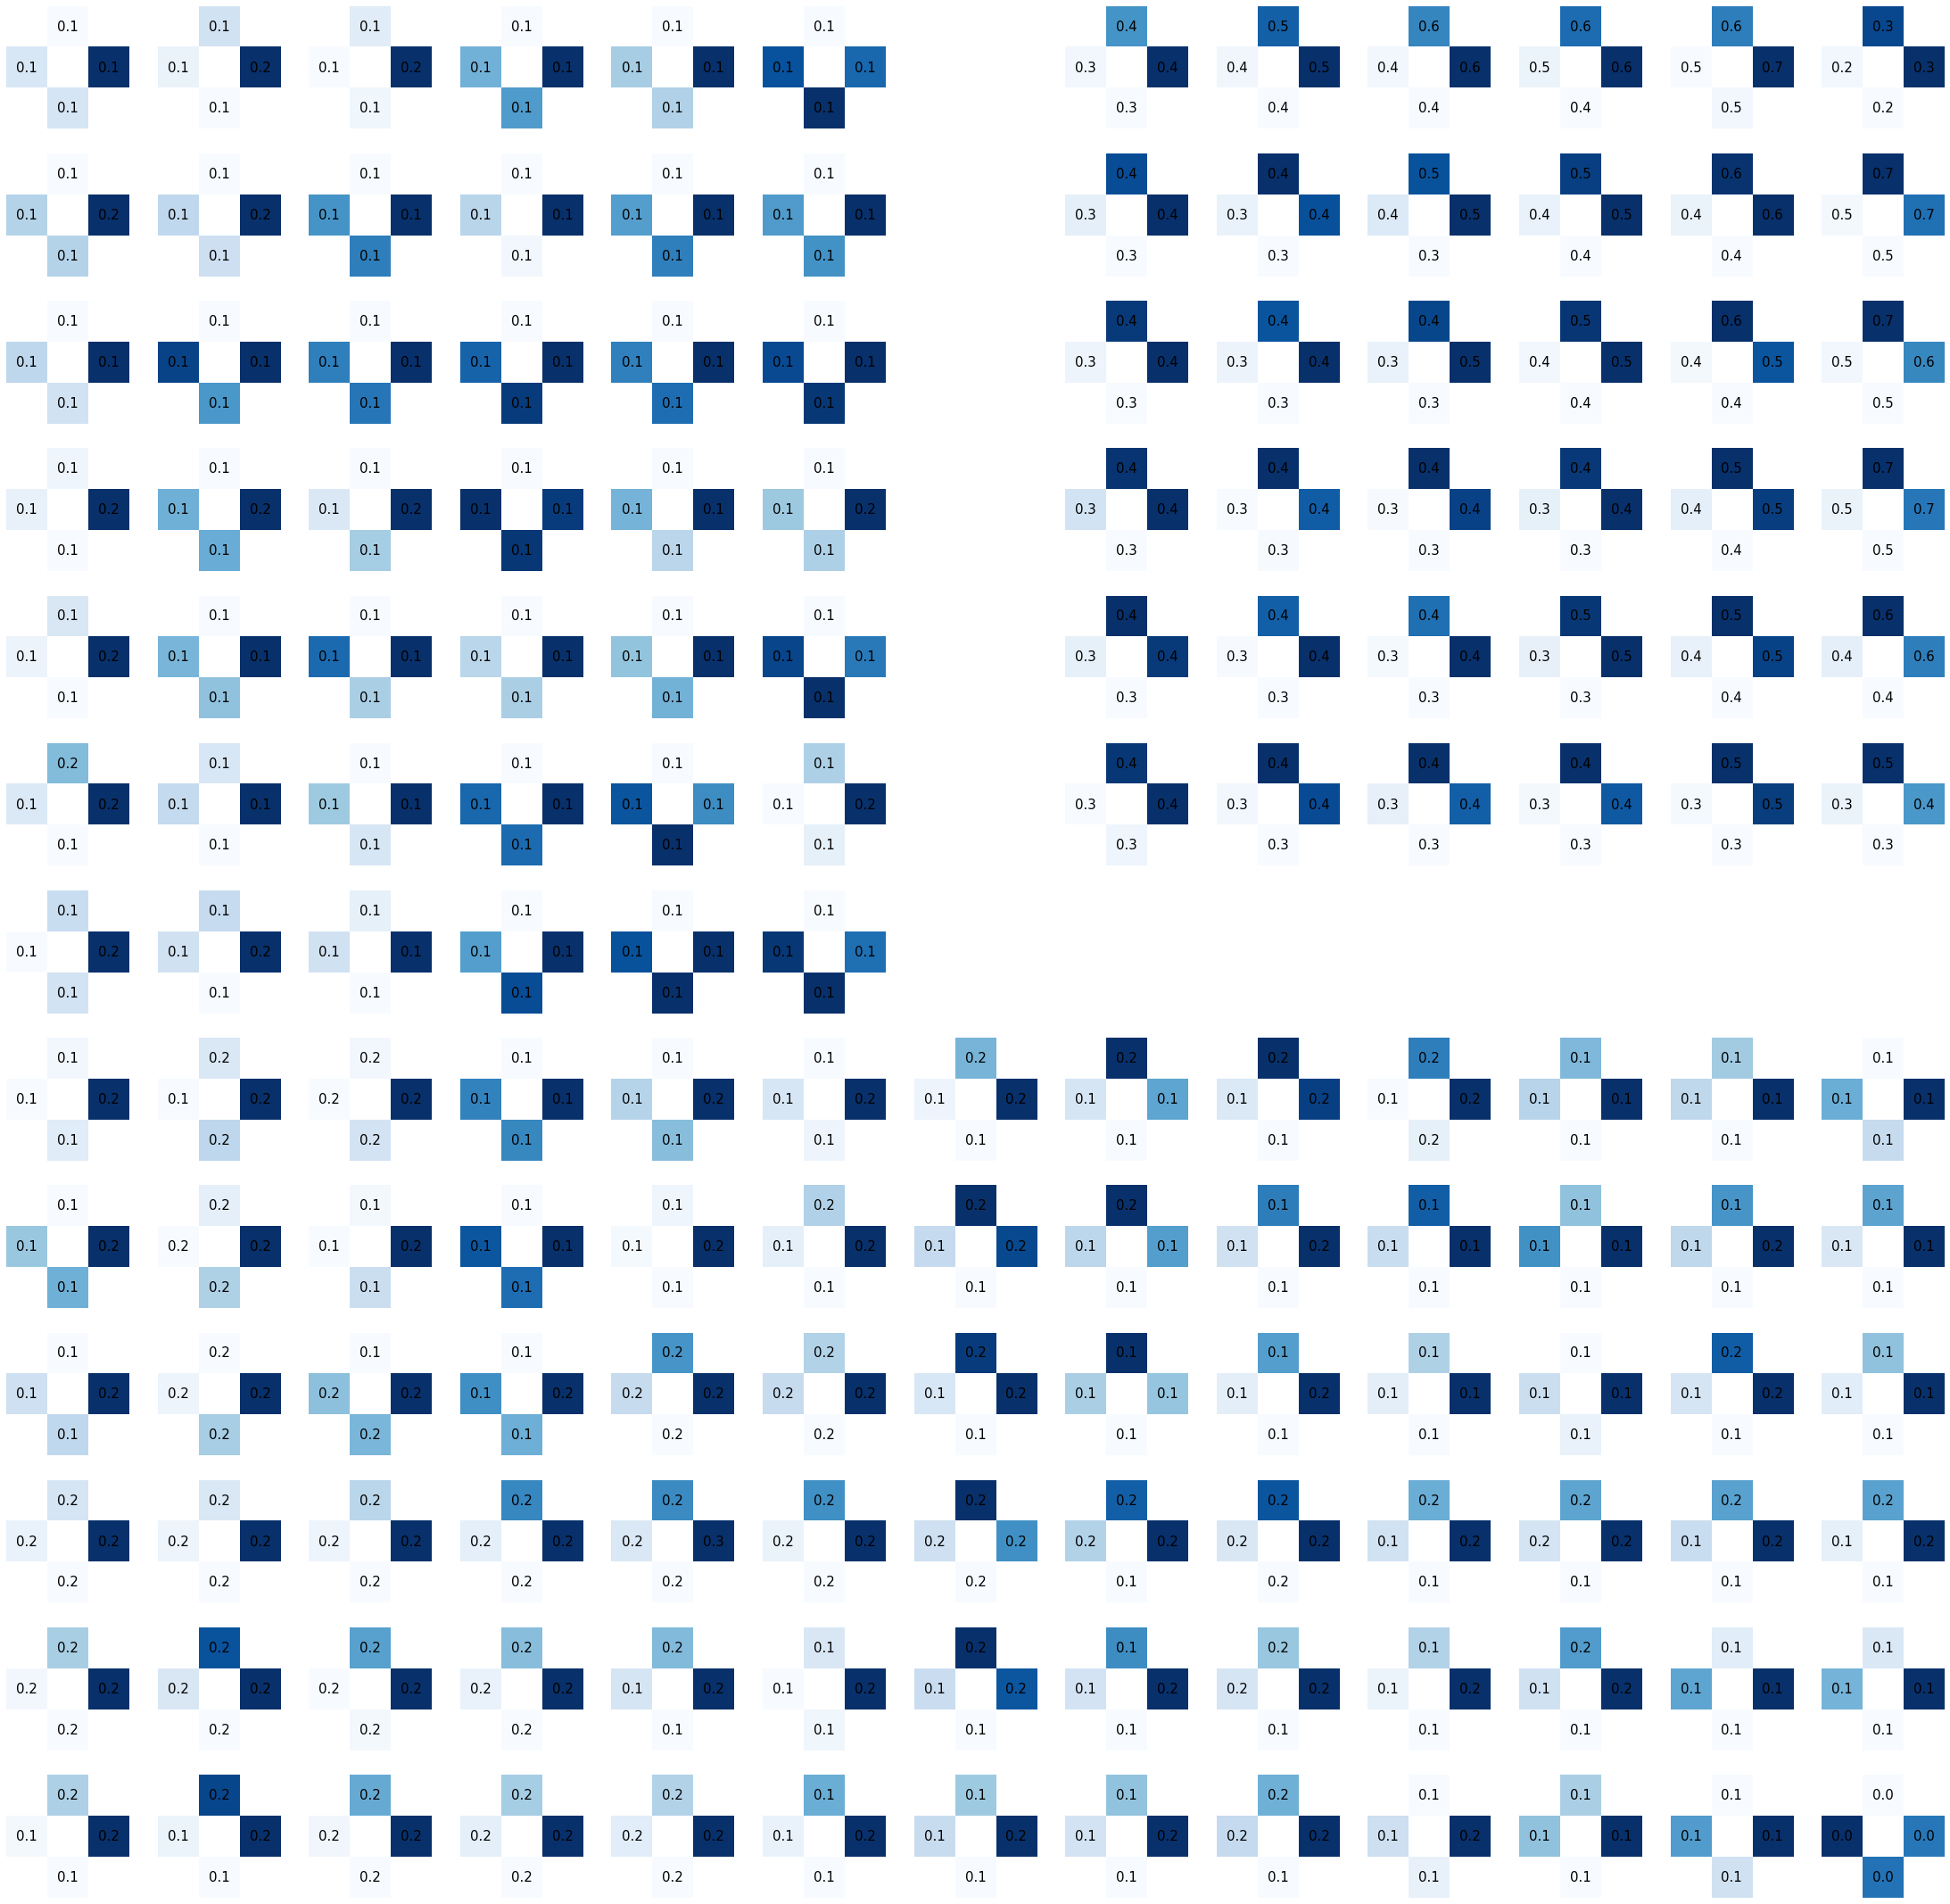

In [133]:
num_row, num_col = env.maze_dim
plt.figure(1, figsize=(num_row*3, num_col*3))
for i,row in enumerate(range(num_row-1,-1,-1)):
# for i,row in enumerate(range(num_row)):
    for col in range(num_col):
        if [row,col] not in env.obstacles:
            ax = plt.subplot(num_row, num_col, i*num_col + col + 1)
            state = [row,col]
            #            state_occupancy_map = mask_grid(np.mean(agent.m[:,state,:],axis=0).reshape(7,7),env.obstacles)
            action_values_map = mask_grid(get_action_values_matrix(state), [[0,0],[1,1],[0,2],[2,0],[2,2]])
            plt.axis('off')
#            ax.imshow(action_values_map,origin='lower',cmap='Greys')
            ax.matshow(action_values_map,cmap='Blues')
#             ax.text(i+0.5, j+0.5, str(c), va='center', ha='center')
#             ax.set_ylim(0,6)
            for (x, y), z in np.ndenumerate(action_values_map):
                if [x, y] not in [[0,0],[1,1],[0,2],[2,0],[2,2]]:
                    ax.text(y, x, '{:0.1f}'.format(z), ha='center', va='center')

### Params

In [46]:
import pandas as pd
import random

In [74]:
MAX_EVALS=4

In [75]:
from fastprogress.fastprogress import master_bar, progress_bar

In [76]:
# mb = master_bar(range(1))
# for j in mb:
#     for i in progress_bar(range(MAX_EVALS),parent=mb):
#         print(i)

In [77]:
def random_search(param_grid, mb=master_bar(range(1)), max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for j in mb:
        for i in progress_bar(range(MAX_EVALS),parent=mb):

            # Choose random hyperparameters
            hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
            print(hyperparameters)
            # Evaluate randomly selected hyperparameters
            eval_results = objective(hyperparameters, i)

            results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [78]:
NNAgent = reload(NNAgent)
FPPAgent = reload(FPPAgent)
agents = {
#     "NN": NNAgent,
#     "RNN": RNNAgent,
#     "GRU": RNNAgentGRU,
    "FPP": FPPAgent,
#     "UORO": UOROAgent,
}
agent_infos = {
#     "NN": {},
#     "RNN": {},
#     "GRU": {},
    "FPP": {},
#     "UORO": {}
}
param_grid = dict(
    discount=[.9],
    beta=[1.5, .5],
    step_size=[1e-3],
)

In [89]:
def objective(hyper_params, i):
    all_reward_sums = {} # Contains sum of rewards during episode
    num_runs = 1
    num_episodes = 500
    Environment = envs['Grid-World']

    for algorithm in tqdm(list(agents.keys())):
        all_reward_sums[algorithm] = []
        all_state_visits[algorithm] = []

        for run in tqdm(range(num_runs)):
            agent = agents[algorithm]()
            env = Environment()

            env.env_init(env_info)
            agent_info = {"num_actions": 4, "num_states": env.cols * env.rows, "epsilon": .1, "step_size": 0.5, "discount": 0.9} 
            agent_info["seed"] = run
            agent_info.update(agent_infos[algorithm])
            agent_info.update(hyper_params)
#             print(hyper_params)
#             agent_info['step_size'] = 1e-2 * 4 / agent_info['num_tilings']
            np.random.seed(run)
            agent.agent_init(agent_info)
            reward_sums = []
            state_visits = np.zeros(env.cols * env.rows)
            epsilon = 1
            for episode in range(num_episodes):
#                 print(f"episode {episode}",end='\r')
#                 print("")
                agent.epsilon = epsilon
                sum_of_rewards = run_episode(env, agent) 

                reward_sums.append(sum_of_rewards)
                epsilon *= 0.99
            all_reward_sums[algorithm].append(reward_sums)
            print(np.mean(all_reward_sums[algorithm]))
    return np.mean(all_reward_sums[algorithm]), hyper_params, i

In [90]:
df = random_search(param_grid)
# NN: {'discount': 0.8, 'step_size': 0.003}
# RNN :{.9, .001}
# GRU:  0.9, 'step_size': 0.0003} 
# FPP: {'discount': 0.9, 'beta': 1.5, 'step_size': 0.001}
# UORO: {'discount': 0.9, 'step_size': 0.0003} 
# GRU FPP: {'discount': 0.9, 'beta': 0.5, 'step_size': 0.001}

  0%|          | 0/1 [00:00<?, ?it/s]

{'discount': 0.9, 'beta': 1.5, 'step_size': 0.001}
> <ipython-input-89-2983b572d6dd>(23)objective()
-> np.random.seed(run)


(Pdb)  agent_info


{'num_actions': 4, 'num_states': 49, 'epsilon': 0.1, 'step_size': 0.001, 'discount': 0.9, 'seed': 0, 'beta': 1.5}


(Pdb)  n


> <ipython-input-89-2983b572d6dd>(24)objective()
-> agent.agent_init(agent_info)


(Pdb)  n


> <ipython-input-89-2983b572d6dd>(25)objective()
-> reward_sums = []


(Pdb)  agent.beta


1.5


(Pdb)  q


  0%|          | 0/1 [00:15<?, ?it/s]


BdbQuit: 

In [73]:
df['params'][1]

{'discount': 0.9, 'beta': 1.5, 'step_size': 0.001}

In [91]:
pd.options.display.width = 0
pd.set_option("display.max_colwidth", 100)

In [92]:
df

,index,score,params,iteration
0,2,-91.04,"{'discount': 0.9, 'beta': 1.5, 'step_size': 0.001}",2
1,1,-110.536,"{'discount': 0.9, 'beta': 1.5, 'step_size': 0.001}",1
2,0,-142.886,"{'discount': 0.9, 'beta': 0.5, 'step_size': 0.001}",0
3,3,-143.424,"{'discount': 0.9, 'beta': 1.5, 'step_size': 0.001}",3
